In [3]:
import pandas as pd
import os
import sys
import fnmatch
import numpy as np
import re
import string
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from scipy import sparse
from nltk.stem.snowball import SnowballStemmer

def vectorize(df, binary):
    nFeatures=1000
    tf_vectorizer = CountVectorizer(max_df=0.90, min_df=0.1,
                                max_features=nFeatures,
                                stop_words='english', binary=binary)
    tf = tf_vectorizer.fit_transform(df)
    features = tf_vectorizer.get_feature_names()
    return (tf, features)

def runMNB(X, y):
    model = MultinomialNB()
    model.fit(X, y)
    return model

def runBNB(X, y):
    model = BernoulliNB()
    model.fit(X, y)
    return model

def runGNB(X, y):
    X=X.toarray()
    model = GaussianNB()
    model.fit(X, y)
    return model

# def runLSA(n, iters, wordMat):
#     print('Number of inputs:', np.shape(wordMat)[0], '\n')
#     lsa = TruncatedSVD(n_components=n, n_iter=5,
#                                 random_state=0)
#     model=lsa.fit(wordMat)
#     lsaTransform=lsa.transform(wordMat)
#     return (model, lsaTransform)
  
# def lsaTopFeatures(model, nWords, featureNames):
#     words=[]
#     for topicIndex, topic in enumerate(model.components_):
#         words.extend([featureNames[i] for i in topic.argsort()[: -nWords-1:-1]])
#     return words

def subWordMatrix(wordMat, indices):
    subWordMat=np.empty((0, np.shape(wordMat)[1]))
    for index in indices:
        vec=wordMat[index]
        subWordMat=np.append(subWordMat, vec, axis=0)
    return subWordMat

def calcRMSE(A,B):
    sse=0
    n=len(A)
    for a, b in zip(A, B):
        sse+=(float(a)-float(b))**2
    rmse=(sse/n)**2
    print('RMSE', rmse)
    

In [4]:
df=pd.DataFrame(columns=['Name', 'Publisher', 'GameSpotScore', 'Review', 'Console', 'Genre'])
i=0
stemmer = SnowballStemmer('english')
for dirpath, dirs, files in os.walk('dataset/reviews'):   
    for file in fnmatch.filter(files, '*.txt'):
        with open(os.path.join(dirpath, file), 'r') as ip:
            data=ip.read()
            name=re.findall(r':::Game Name:::(.*?)-----', data, re.DOTALL)[0].strip()
            review=re.findall(r':::Review:::(.*?)-----',data, re.DOTALL)[0].strip()
            scores=re.findall(r':::Scores:::(.*?)-----',data, re.DOTALL)[0]
            addition=re.findall(r':::Addition:::(.*?)-----',data, re.DOTALL)[0]
            gsScore=re.findall(r'GameSpot Score:(.*?)\n', scores)[0]
            review = review.lower()
            tVar = str.maketrans('', '', string.punctuation)
            review = review.translate(tVar)
            words=review.split()
            reviewStr=''
            for word in words:
                word=stemmer.stem(word)
                reviewStr+=word+' '
#             print(reviewStr)
#             sys.exit(0)
            try:
                pub=re.findall(r'Publisher:(.*?)\n', addition)[0]
            except:
                pub=''
            try:
                genre=re.findall(r'Genre:(.*?)\n', addition)[0]
            except:
                genre=''
            console=dirpath.strip('dataset/reviews/')
            df.loc[i]=[name, pub, gsScore, reviewStr, console, genre]
            i+=1

In [33]:
n=len(df)
train_ratio=0.9
wordMat, features=vectorize(df['Review'], False)
n_train=int(n*train_ratio)
n_test=n-n_train

wordMat=wordMat.todense()
testRows=random.sample((list(df.index)), n_test)
test_df=df.ix[testRows]
train_df=df.drop(testRows)

subWordMatTest=subWordMatrix(wordMat, test_df.index)
subWordMatTest=sparse.csr_matrix(subWordMatTest, dtype='int')

subWordMatTrain=subWordMatrix(wordMat, train_df.index)
subWordMatTrain=sparse.csr_matrix(subWordMatTrain, dtype='int')

In [34]:
model=runMNB(subWordMatTrain, train_df['GameSpotScore'])
pred=model.predict(subWordMatTest)
for a, b in enumerate(pred):
    game=test_df.iloc[a]
    print(game['Name'], 'Original Score', game['GameSpotScore'], 'Predicted Score', b)
    if(a==10):
        break

The Sims: Hot Date Original Score  8.8 Predicted Score  9.2
Huygen's Disclosure Original Score  2.9 Predicted Score  5.2
Madden NFL 06 Original Score  8.1 Predicted Score  8.8
Kirby: Canvas Curse Original Score  8.6 Predicted Score  6.3
Grand Prix Legends Original Score  8.9 Predicted Score  8.8
50 Cent: Bulletproof Original Score  4.8 Predicted Score  4.8
Machine Hunter Original Score  3.1 Predicted Score  2
Dark Messiah of Might and Magic: Elements Original Score  3.5 Predicted Score  5
Frogger Helmet Chaos Original Score  7.3 Predicted Score  6.1
Fighting Legends Original Score  4 Predicted Score  6.3
Pokemon Emerald Original Score  7.5 Predicted Score  7.5


RMSE 4.516292295181921


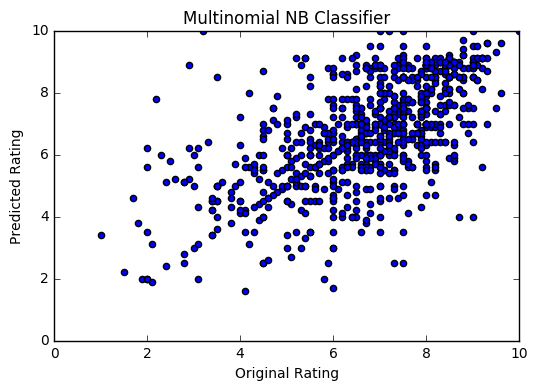

In [35]:
calcRMSE(test_df['GameSpotScore'], pred)
x_val=test_df['GameSpotScore']
x_val=list(x_val)
y_val=pred
plt.scatter(x_val, y_val)
plt.title('Multinomial NB Classifier')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Original Rating')
plt.ylabel('Predicted Rating')
plt.show()


In [36]:
model=runGNB(subWordMatTrain, train_df['GameSpotScore'])
subDense=subWordMatTest.toarray()
pred=model.predict(subDense)
for a, b in enumerate(pred):
    game=test_df.iloc[a]
    print(game['Name'], 'Original Score', game['GameSpotScore'], 'Predicted Score', b)
    if(a==10):
        break

The Sims: Hot Date Original Score  8.8 Predicted Score  8
Huygen's Disclosure Original Score  2.9 Predicted Score  2
Madden NFL 06 Original Score  8.1 Predicted Score  8.2
Kirby: Canvas Curse Original Score  8.6 Predicted Score  4
Grand Prix Legends Original Score  8.9 Predicted Score  9.1
50 Cent: Bulletproof Original Score  4.8 Predicted Score  4.8
Machine Hunter Original Score  3.1 Predicted Score  4.2
Dark Messiah of Might and Magic: Elements Original Score  3.5 Predicted Score  5
Frogger Helmet Chaos Original Score  7.3 Predicted Score  6.5
Fighting Legends Original Score  4 Predicted Score  8.5
Pokemon Emerald Original Score  7.5 Predicted Score  7.5


RMSE 8.608625306454057


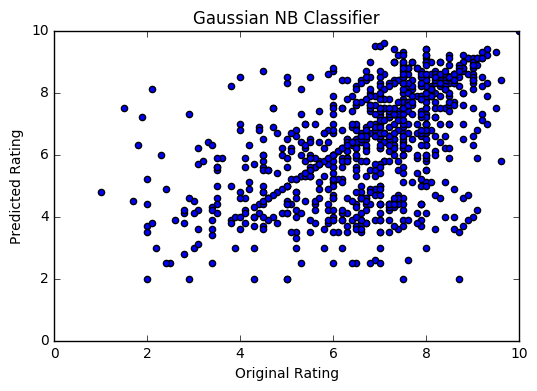

In [37]:
calcRMSE(test_df['GameSpotScore'], pred)
x_val=test_df['GameSpotScore']
x_val=list(x_val)
y_val=pred
plt.scatter(x_val, y_val)
plt.title('Gaussian NB Classifier')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Original Rating')
plt.ylabel('Predicted Rating')
plt.show()

In [38]:
n=len(df)
train_ratio=0.9
wordMat, features=vectorize(df['Review'], True)
n_train=int(n*train_ratio)
n_test=n-n_train

wordMat=wordMat.todense()
testRows=random.sample((list(df.index)), n_test)
test_df=df.ix[testRows]
train_df=df.drop(testRows)

subWordMatTest=subWordMatrix(wordMat, test_df.index)
subWordMatTest=sparse.csr_matrix(subWordMatTest, dtype='int')

subWordMatTrain=subWordMatrix(wordMat, train_df.index)
subWordMatTrain=sparse.csr_matrix(subWordMatTrain, dtype='int')

In [39]:
model=runMNB(subWordMatTrain, train_df['GameSpotScore'])
pred=model.predict(subWordMatTest)
for a, b in enumerate(pred):
    game=test_df.iloc[a]
    print(game['Name'], 'Original Score', game['GameSpotScore'], 'Predicted Score', b)
    if(a==10):
        break   

NCAA Football 2004 Original Score  8.3 Predicted Score  8.8
Gorasul: Legacy of the Dragon Original Score  6.4 Predicted Score  8.4
Battleground 7: Bull Run Original Score  7.1 Predicted Score  7.1
Evergrace Original Score  5.2 Predicted Score  7.3
Minority Report: Everybody Runs Original Score  4.1 Predicted Score  4.1
Splashdown: Rides Gone Wild Original Score  8.2 Predicted Score  8
UEFA Champions League 2006-2007 Original Score  7.6 Predicted Score  8
Wii Music Original Score  6.5 Predicted Score  6
Neo Contra Original Score  6.8 Predicted Score  6.6
Godzilla Unleashed: Double Smash Original Score  2 Predicted Score  3.5
Driver '76 Original Score  6 Predicted Score  5.8


RMSE 2.366729556261516


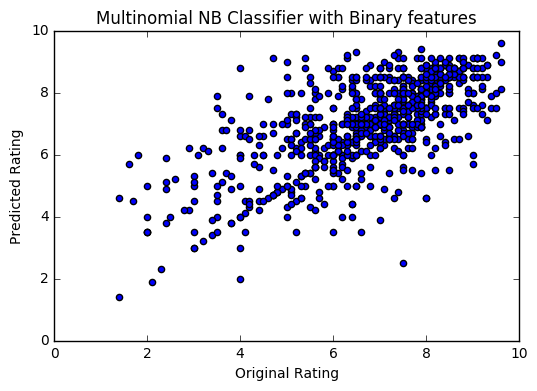

In [40]:
calcRMSE(test_df['GameSpotScore'], pred)

x_val=test_df['GameSpotScore']
x_val=list(x_val)
y_val=pred
plt.scatter(x_val, y_val)
plt.title('Multinomial NB Classifier with Binary features')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Original Rating')
plt.ylabel('Predicted Rating')
plt.show()

In [41]:
model=runBNB(subWordMatTrain, train_df['GameSpotScore'])
pred=model.predict(subWordMatTest)
for a, b in enumerate(pred):
    game=test_df.iloc[a]
    print(game['Name'], 'Original Score', game['GameSpotScore'], 'Predicted Score', b)
    if(a==10):
        break    

NCAA Football 2004 Original Score  8.3 Predicted Score  8.8
Gorasul: Legacy of the Dragon Original Score  6.4 Predicted Score  8.4
Battleground 7: Bull Run Original Score  7.1 Predicted Score  4
Evergrace Original Score  5.2 Predicted Score  5.8
Minority Report: Everybody Runs Original Score  4.1 Predicted Score  4.1
Splashdown: Rides Gone Wild Original Score  8.2 Predicted Score  8
UEFA Champions League 2006-2007 Original Score  7.6 Predicted Score  8.8
Wii Music Original Score  6.5 Predicted Score  5
Neo Contra Original Score  6.8 Predicted Score  9
Godzilla Unleashed: Double Smash Original Score  2 Predicted Score  3.5
Driver '76 Original Score  6 Predicted Score  5.8


RMSE 6.105852937203903


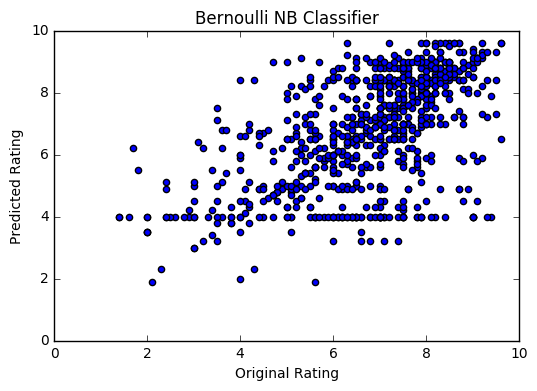

In [42]:
calcRMSE(test_df['GameSpotScore'], pred)

x_val=test_df['GameSpotScore']
x_val=list(x_val)
y_val=pred
plt.scatter(x_val, y_val)
plt.title('Bernoulli NB Classifier')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Original Rating')
plt.ylabel('Predicted Rating')
plt.show()